In [16]:
from torch_DE.geometry.shapes import *
from torch_DE.continuous import DE_Getter
from torch_DE.continuous.Networks import MLP
from torch_DE.continuous.utils import *
from torch_DE.continuous.Engines import FD_engine

from torch_DE.equations import get_NavierStokes
from torch.optim.lr_scheduler import StepLR
from matplotlib.patches import Circle as pltCircle
from torch_DE.post import Plotter
from importlib import reload
reload(Plotter)

<module 'torch_DE.post.Plotter' from 'C:\\Users\\John Su\\Downloads\\Py_DE\\Pytorch_PINNs\\src\\torch_DE\\post\\Plotter.py'>

(None, (0.0, 0.0, 1.0, 0.41))

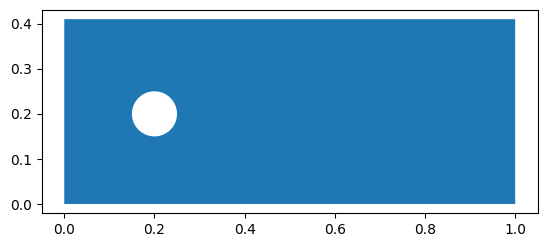

In [2]:
(xmin,xmax),(ymin,ymax) = (0,1), (0,0.41)
domain = Rectangle(((xmin,ymin),(xmax,ymax) ),'corners')
domain = Domain2D(base = domain)

hole = Circle((0.2,0.2),r = 0.05,num_points= 512)
domain.remove(hole,names= ['Cylinder'])

domain.plot(),domain.bounds

In [3]:
sdf = domain.create_sdf(resolution = 100,device='cuda')

c:\Users\John Su\Downloads\Py_DE\env\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


C:\Users\John Su\Downloads\Py_DE\Pytorch_PINNs\src\torch_DE\continuous\utils\GridInterpolator.py:63: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  idx_right = torch.bucketize(x, p)


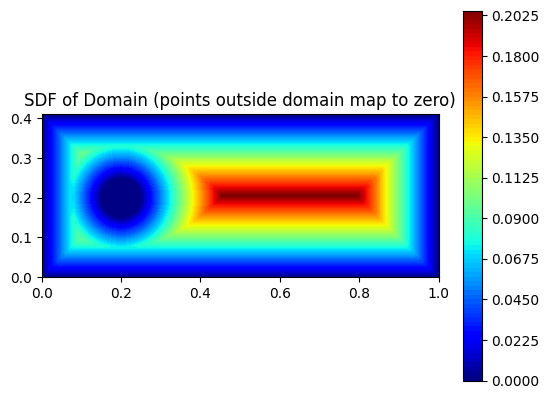

In [4]:
domain.plot_sdf()

In [5]:
sampled_points = domain.generate_points(400_000)

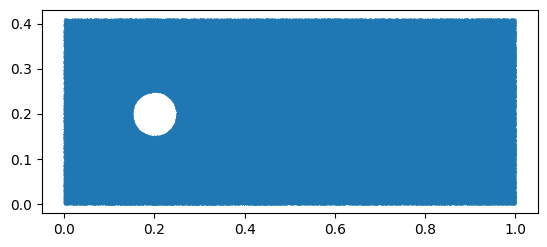

In [6]:
plt.gca().set_aspect('equal')
plt.scatter(sampled_points[:,0],sampled_points[:,1],s=0.1)

In [7]:
domain.add_boundary_group('Cylinder','Cyl_No_Slip')
b_groups =domain.boundary_groups 
cyl = b_groups['Cyl_No_Slip']
cyl_points = torch.tensor(list(cyl.coords))
inlet = domain.generate_points_from_line(b_groups['exterior_edge_0'],100,random = False)
outlet = domain.generate_points_from_line(b_groups['exterior_edge_2'],100,random = False)
top = domain.generate_points_from_line(b_groups['exterior_edge_1'],100,random = False)
bot = domain.generate_points_from_line(b_groups['exterior_edge_3'],100,random = False)

In [8]:
input_vars,output_vars,derivatives,equations = get_NavierStokes(dims = 2,steady_state= True,Re=100)
(NS_x,NS_y,incomp) = list(equations.values())
input_vars,output_vars,sorted(derivatives)

(('x', 'y'),
 ('u', 'v', 'p'),
 ['p_x', 'p_y', 'u_x', 'u_xx', 'u_y', 'u_yy', 'v_x', 'v_xx', 'v_y', 'v_yy'])

In [9]:
U = 0.3
u_inlet_func = lambda x : 4*U*x[:,1]*(0.41-x[:,1])/(0.41**2)

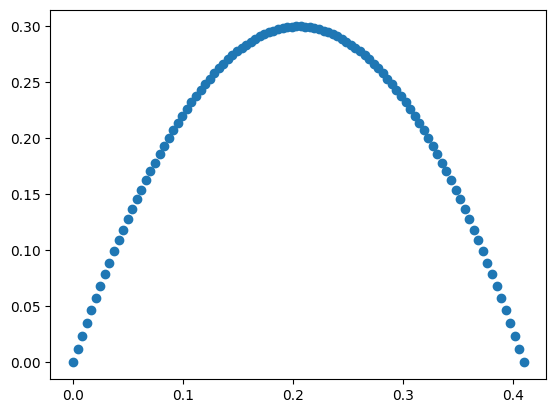

In [10]:
test = u_inlet_func(inlet)
plt.scatter(inlet[:,1],test)

In [17]:
#DATA
data  = Data_handler()
data['collocation points'] = sample_from_tensor(2000,sampled_points,0)
data['inlet'] = inlet
data['outlet'] = outlet
data['no_slip_walls'] = torch.cat([top,bot],dim = 0)
data['cylinder'] = cyl_points
data.set_to_device('cuda')
#PYTORCH SETUP
torch.manual_seed(1234)


net = MLP(2,3,128,6,activation='sin')
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
LR_sch = StepLR(optimizer,10000,0.9)

#SET UP DERIVATIVES
PINN = DE_Getter(net)
PINN.set_vars(input_vars,output_vars)
PINN.set_derivatives(derivatives)
FD = FD_engine(net = net,derivatives= PINN.derivatives,dxs = [0.01,0.01],sdf= sdf)
PINN.set_deriv_method(FD)

#LOSSES
losses = Loss_handler(data.group_names())
losses.add_boundary('inlet',{'u':u_inlet_func,
                             'v':0})

losses.add_boundary('outlet',{'u':u_inlet_func,
                             'v':0})


losses.add_boundary('cylinder',{'u':0,
                                'v':0 })

losses.add_boundary('no_slip_walls',{'u':0,
                                     'v':0 })

losses.add_residual('collocation points',{'stokes_x':NS_x,
                                          'stokes_y':NS_y, 
                                          'incomp':incomp },weighting=sdf)
#SAMPLING STRATEGY
sampler = R3_sampler(sample_from_tensor)

#Post Processing
plotter= Plotter.Plotter(input_vars,output_vars)
plotter.set_contour_points(domain)

Set all tensors to device cuda
dict_keys(['u', 'v', 'p', 'p_x', 'v_y', 'v_yy', 'v_x', 'v_xx', 'u_y', 'u_x', 'u_xx', 'u_yy', 'p_y'])


c:\Users\John Su\Downloads\Py_DE\env\lib\site-packages\torch\_functorch\deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')


In [ ]:
net= net.cuda()
for i in range(100_000):
    data.set_to_device('cuda',to_show= False)
    output = PINN.calculate(data,target_group = 'collocation points')
    loss = losses.calculate(data,output,output_type= None)

    optimizer.zero_grad()
    
    loss.sum().backward()
    optimizer.step()
    LR_sch.step()

    data['collocation points'] = sampler(data['collocation points'],*loss.point_error()['Residual']['collocation points'].values(),t=sampled_points)
    if (i % 500) == 0:
        losses.log_loss()
        losses.print_losses(i)
    if (i % 10_000 == 0):        
        plotter.validate_contour(net,['x','y'],'u',save_dir='',epoch=i,show = False)